<h1 style="text-align:center">Ch 4.3. LDA<h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

 ## 1. Fit a linear model

### 1-1. Sample estimates (Gaussian Parameters)

In [2]:
def prior_hat(N, N_k):
    return N_k/N

In [3]:
def mu_hat(x, N_k):
    return np.sum(x, axis=0)/N_k # row vector

In [4]:
def sig(x, mu_hat):
    r,c = x.shape 
    S = (x[0,:]-mu_hat).T*(x[0,:]-mu_hat)
    for i in range(1,r):
        S += (x[i,:]-mu_hat).T*(x[i,:]-mu_hat)
    return S

### 1-2. Discrimination Function

$$\delta_k(x) = x^T \Sigma^{-1}\mu_k - \frac{1}{2}\mu^T_k \Sigma^{-1}\mu_k + \log \pi_k$$

In [5]:
def Delta(x, sig_hat, mu_hat, prior_hat):
    return (x - 1/2 * mu_hat ) * np.linalg.inv(sig_hat) * mu_hat.T + np.log(prior_hat)  

In [6]:
def Deltas(x, sig_hat, mu_hats, prior_hats):
    return [Delta(x, sig_hat, mu, prior) for (mu, prior) in zip(mu_hats, prior_hats)]

numpy는 행렬에 스칼라 덧셈/뺄셈이 그냥 됨, 원소 연산기호가 따로 없음

In [7]:
def find_G_hat(deltas):
    return np.argmax(deltas, axis=0)[(0,0)]

## 2. Implementation for Example
- $N = 100$
- $K = 3$
- $p=2$

::LDA assumption::
 The classes have a common covariance matrix

In [8]:
# Input variables
feature = 2
N=100
K=3

np.random.seed(15)

x1_x = np.matrix(np.random.normal(loc=0.8,scale=0.1,size=(40,1))) # loc=mean, scale=variation
x1_y = np.matrix(np.random.normal(loc=1,scale=0.4,size=(40,1)))
x1 = np.column_stack([x1_x, x1_y])

x2_x = np.matrix(np.random.normal(1.5,0.1, size=(30,1)))
x2_y = np.matrix(np.random.normal(3,0.4, size=(30,1)))
x2 = np.column_stack([x2_x, x2_y])

x3_x = np.matrix(np.random.normal(2.2,0.1, size=(30,1)))
x3_y = np.matrix(np.random.normal(0.8, 0.4, size=(30,1)))
x3 = np.column_stack([x3_x, x3_y])

In [9]:
# data size of subsets
n1,_ = x1.shape 
n2,_ = x2.shape
n3,_ = x3.shape

### 2-1. Estimated Gaussian parameters

In [10]:
xs = [x1, x2, x3]
ns = [x.shape[0] for x in xs]
prior_hats = [prior_hat(N, n) for n in ns] # estimated prior probabilities 
mu_hats_trsp = [mu_hat(x,n) for (x,n) in zip(xs, ns)] # estimated means 
sigs = [sig(x, mu) for (x, mu) in zip(xs, mu_hats_trsp)]  # sigs = sig1 + sig2 + ... + sigK
sig_hat = 1/(N-K) * np.add.reduce(sigs) # = sigs[0]+sigs[1]+sigs[2]

### 2-2. New data

In [11]:
new_x = np.matrix("1.7 1.7")

In [12]:
new_x.shape

(1, 2)

In [13]:
G = find_G_hat(Deltas(new_x, sig_hat, mu_hats_trsp, prior_hats))
print(G)
if G == 0:
    print("Cat")
elif G == 1:
    print("Dog")
else:
    print("Rabbit")

1
Dog


## 3. Plotting

In [14]:
x11 = np.asarray(x1[:,0]).ravel()
x12 = np.asarray(x1[:,1]).ravel()
x21 = np.asarray(x2[:,0]).ravel()
x22 = np.asarray(x2[:,1]).ravel()
x31 = np.asarray(x3[:,0]).ravel()
x32 = np.asarray(x3[:,1]).ravel()

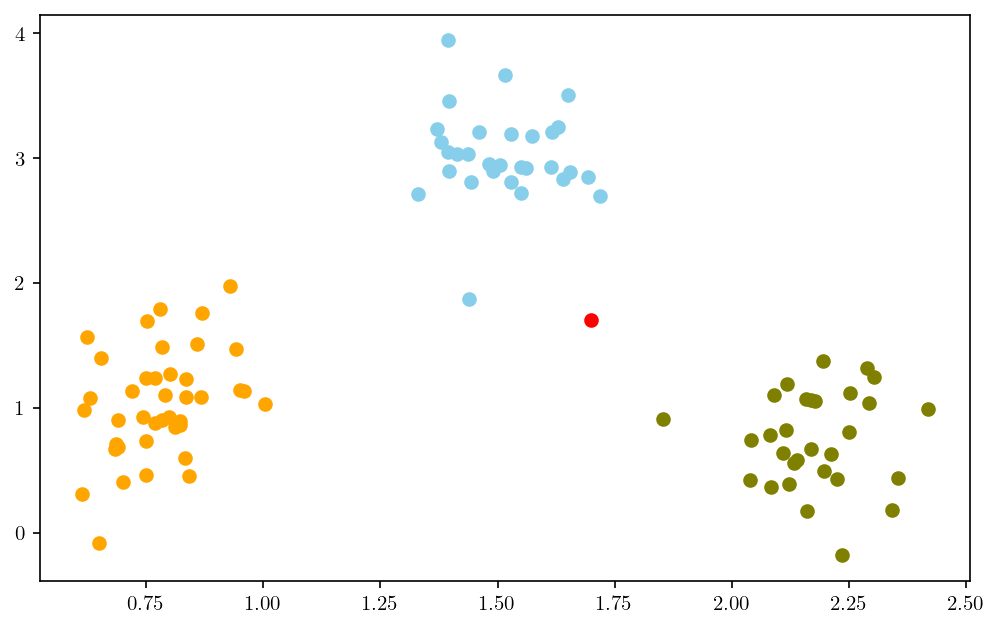

In [15]:
# Use latex
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Prepare Plot
plt.figure(figsize=(8,5), dpi=150)

plt.scatter(x11, x12, color="orange")
plt.scatter(x21, x22, color="skyblue")
plt.scatter(x31, x32, color="olive")
plt.scatter(new_x[0,0],new_x[0,1], color="red")

### 3-1. Decision Boundaries

In [16]:
def find_boundary(x, mu1, mu2, mu1_trsp, mu2_trsp, N1, N2):
    
    diff_mu = mu2 - mu1
    inv_sig = np.linalg.inv(sig_hat)
    log = np.log(N2/N1)
    coeff = inv_sig * diff_mu
    print(coeff)
    return (-x* coeff[0,0] + 1/2 * ((mu2_trsp+mu1_trsp) * coeff)[0,0] - log) / coeff[1,0]

In [17]:
domain = np.arange(0.5,3) 

mu0 = mu_hats_trsp[0].T
mu1 = mu_hats_trsp[1].T
mu2 = mu_hats_trsp[2].T

B12 = np.asarray(find_boundary(domain, mu0, mu1, mu_hats_trsp[0], mu_hats_trsp[1], n1, n2)).ravel()
B23 = np.asarray(find_boundary(domain, mu1, mu2, mu_hats_trsp[1], mu_hats_trsp[2], n2, n3)).ravel()
B31 = np.asarray(find_boundary(domain, mu2, mu0, mu_hats_trsp[2], mu_hats_trsp[0], n3, n1)).ravel()

[[60.70179211]
 [10.43522507]]
[[ 68.5796047 ]
 [-16.91906678]]
[[-129.28139681]
 [   6.48384171]]


(-2.0, 5.0)

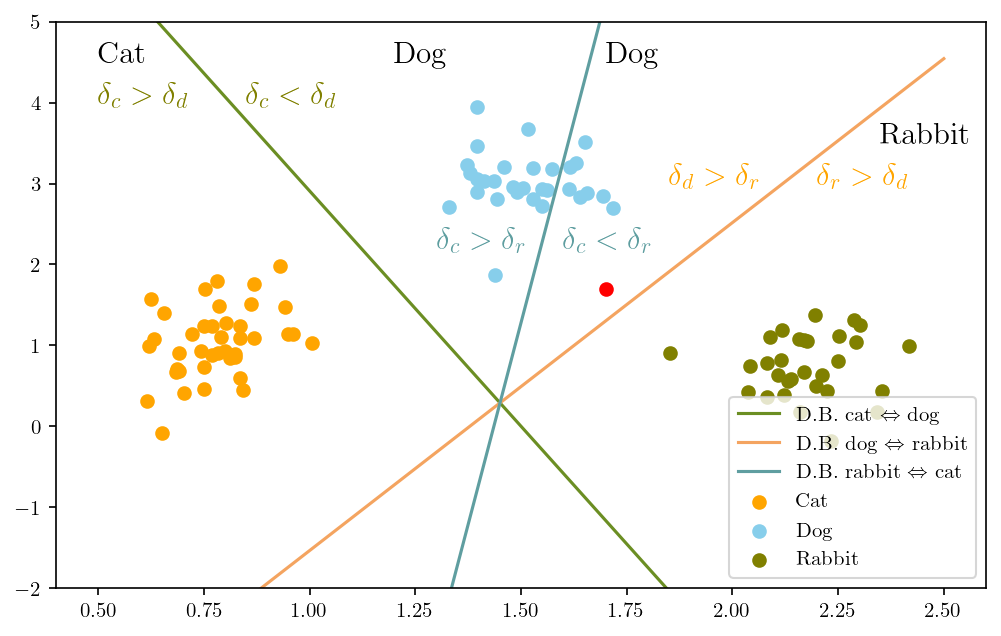

In [18]:
plt.figure(figsize=(8,5), dpi=150)

plt.scatter(x11, x12, color="orange", label="Cat")
plt.scatter(x21, x22, color="skyblue", label="Dog")
plt.scatter(x31, x32, color="olive", label="Rabbit")
plt.scatter(new_x[0,0],new_x[0,1], color="red")

plt.plot(domain, B12, color="olivedrab", label=r"D.B. cat $\Leftrightarrow$ dog")
plt.plot(domain, B23, color="sandybrown", label=r"D.B. dog $\Leftrightarrow$ rabbit")
plt.plot(domain, B31, color="cadetblue", label="D.B. rabbit $\Leftrightarrow$ cat")

# Annotation
plt.annotate('Cat', xy=(0.5,4.5), fontsize=15)
plt.annotate('$\delta_c > \delta_d$', color="olive",xy=(0.5,4), fontsize=15)

plt.annotate('Dog', xy=(1.2,4.5), fontsize=15)
plt.annotate('$\delta_c < \delta_d$', color="olive",xy=(0.85,4), fontsize=15)

plt.annotate('$\delta_c > \delta_r$', color="cadetblue",xy=(1.3,2.2), fontsize=15)
plt.annotate('$\delta_c < \delta_r$', color="cadetblue",xy=(1.6,2.2), fontsize=15)

plt.annotate('$\delta_d > \delta_r$', color="orange",xy=(1.85,3), fontsize=15)

plt.annotate('Dog', xy=(1.7,4.5), fontsize=15)
plt.annotate('$\delta_r > \delta_d$', color="orange",xy=(2.2,3), fontsize=15)


plt.annotate('Rabbit', xy=(2.35,3.5), fontsize=15)

plt.legend(loc="lower right")
plt.ylim([-2,5])